# Ridge Regression (gradient descent)

In this notebook, you lets implement ridge regression via gradient descent. You will:
* Convert an DataFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

In [13]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

In [3]:
sales = pd.read_csv('data/kc_housing_sales_data.csv')
sales.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [5]:
def get_numpy_data(data_frame, features, output):
    
    data_frame['constant'] = 1 # this is how you add a constant column to a data frame
    
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
   
    # select the columns of data_frame given by the features list into the data frame features_frame (now including constant):
    features_frame = data_frame[features]
       
    # the following line will convert the features_frame into a numpy matrix:
    #feature_matrix = features_frame.to_numpy()
    feature_matrix = features_frame.as_matrix()
       
    # assign the column of data_frame associated with the output to the array output_array
    output_array = data_frame[output]
    
    # the following will convert the array into a numpy array by first converting it to a list
    output_array = output_array.as_matrix()
    
    return(feature_matrix, output_array)

In [6]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

## Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. The cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) and add the derivative of the regularization part.  The derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

Lets complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which should be set to `True` when computing the derivative of the constant and `False` otherwise.

In [7]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    else:
        derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    
    return derivative

To test your feature derivartive run the following:

In [9]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 

my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 

errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


## Gradient Descent

Lets write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. The gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. This time lets set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

Lets complete the following gradient descent function below using derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [29]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    for i in xrange(max_iterations):
    #while not reached maximum number of iterations:
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        
        # compute the errors as predictions - output
        errors = predictions - output
                
        for j in xrange(len(weights)): # loop over each weight
            
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if j == 0:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,j], weights[j], l2_penalty, True)
            else:
                derivative = feature_derivative_ridge(errors, feature_matrix[:,j], weights[j], l2_penalty, False)
            
            # subtract the step size times the derivative from the current weight
            weights[j] = weights[j] - step_size * derivative
            
    return weights

## Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [11]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [14]:
train_data,test_data = train_test_split(sales, test_size = 0.2, train_size = 0.8, random_state = 1)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [15]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

/home/osboxes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [20]:
print test_output

[  459000.   445000.  1057000. ...,   260000.  1795000.   418000.]


Let's set the parameters for our optimization:

In [21]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [22]:
simple_weights_0_penalty = 0.0

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [23]:
simple_weights_high_penalty =  1e11

This code will plot the two learned models. (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

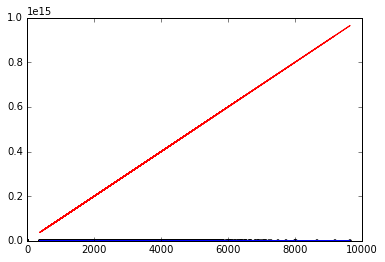

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [25]:
print initial_weights
print step_size
print simple_weights_0_penalty

[ 0.  0.]
1e-12
0.0


In [31]:
weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, simple_weights_0_penalty, max_iterations)
print weights_0_penalty

[ -6.05138456e-02   2.61592130e+02]


In [32]:
weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, simple_weights_high_penalty, max_iterations)
print weights_high_penalty

[   9.8105106   122.84129695]


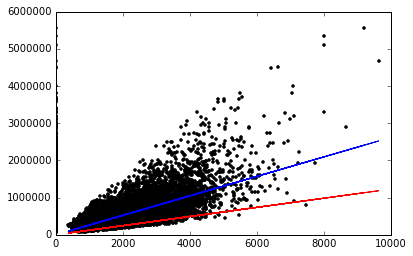

In [33]:
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, weights_high_penalty),'r-')

In [34]:
predictions_0_penalty = predict_output(simple_test_feature_matrix, weights_0_penalty)
predictions_high_penalty = predict_output(simple_test_feature_matrix, weights_high_penalty)

error_0_penalty = test_output - predictions_0_penalty
error_high_penalty = test_output - predictions_high_penalty

rss_0_penalty = np.dot(error_0_penalty, error_0_penalty)
rss_high_penalty = np.dot(error_high_penalty, error_high_penalty)

print rss_0_penalty
print rss_high_penalty

3.74193000996e+14
8.67065394242e+14


## Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [35]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

/home/osboxes/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [37]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [38]:
multiple_weights_0_penalty = 0.0

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [39]:
multiple_weights_high_penalty = 1e11

Lets compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [40]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, multiple_weights_0_penalty, max_iterations)
print multiple_weights_0_penalty

[  -0.29121257  231.9630539    33.09879958]


In [41]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, multiple_weights_high_penalty, max_iterations)
print multiple_weights_high_penalty

[  6.80292178  89.99153674  78.17147406]


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [42]:
predictions_0_penalty = predict_output(test_feature_matrix, multiple_weights_0_penalty)
predictions_high_penalty = predict_output(test_feature_matrix, multiple_weights_high_penalty)

error_0_penalty = test_output - predictions_0_penalty
error_high_penalty = test_output - predictions_high_penalty

rss_0_penalty = np.dot(error_0_penalty, error_0_penalty)
rss_high_penalty = np.dot(error_high_penalty, error_high_penalty)

print rss_0_penalty
print rss_high_penalty

3.7583054359e+14
6.63071055737e+14


In [43]:
print test_output[0]
print predictions_0_penalty[0]
print predictions_high_penalty[0]

459000.0
743163.147958
477780.465202
